<a href="https://colab.research.google.com/github/huy1101/Self-driving-car-Applied-Deep-Learning-/blob/main/Behavioural_Cloning(with_generator).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/rslim087a/track

fatal: destination path 'track' already exists and is not an empty directory.


In [ ]:
!ls track


driving_log.csv  IMG


In [ ]:
!pip3 install imgaug

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPool2D, Dropout, Dense, Flatten
from sklearn.utils import shuffle
from sklearn.model_selection import  train_test_split
from imgaug import augmenters as iaa #image generator
import cv2
import pandas as pd
import random
import ntpath
import os

In [ ]:
datadir = 'track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, "driving_log.csv"), names = columns)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.649786
1,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.627942
2,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.622910
3,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.619162
4,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.615438


In [ ]:
def path_leaf(path): # to remove the directory of the file
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2018_07_16_17_11_43_382.jpg,left_2018_07_16_17_11_43_382.jpg,right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,center_2018_07_16_17_11_43_670.jpg,left_2018_07_16_17_11_43_670.jpg,right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,center_2018_07_16_17_11_43_724.jpg,left_2018_07_16_17_11_43_724.jpg,right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


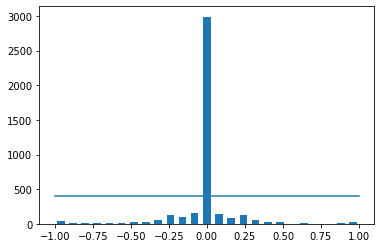

In [ ]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins) # review how it's done
center = (bins[:-1] + bins[1:]) * 0.5
#print(hist)
#print(bins) # we can see that the number of bins always larger than number of hist by 1 so we have to get rid of 1 element in bins(bins[:-1]), 
            # but then the list bins will be unbalanced, so rather doing this we can center the value 
#print(center)
plt.bar(center, hist, width = 0.05) 
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))


total data: 4053
removed 2590
remaining:  1463


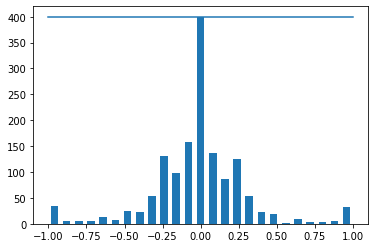

In [ ]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i]  >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i) #value in list_ is the location of the steerig value that is the same as value in bins list
  #print(list_)
  list_ = shuffle(list_)  
  list_ = list_ [samples_per_bin:] # trim off data, only take the first 200 data from each of bin, trim data form index 200 to beyond
  #print(list_)
  remove_list.extend(list_) # add the part that we want to remove in this list

print('removed', len(remove_list))
data.drop(data.index[remove_list], inplace = True) # remove the all data in 'data' (from "steering", "right", 'left') according to the index of 
print('remaining: ', len(data))                    # value stored in remove_list (data stored in remove_list is the position)

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width = 0.05) #plot the bar
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin)) # plot the line

In [ ]:
#print(data.iloc[0]) # value of row index 1
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i] #iloc to output value at row number i'th
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2] #take image address
    image_path.append(os.path.join(datadir, center.strip())) #list of directories of image Track/IMG/center_2018....
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + "/IMG", data) #image_paths, with realted steerings angles

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size = 0.2, random_state = 6) 
# split data to train data, test data
print("Training samples:", len(X_train)) #X_train , X_valid have image directories (use to access image file)
print('validation samples:', len(X_valid)) #y_train, y_valid have steering data

Training samples: 1170
validation samples: 293


Text(0.5, 1.0, 'validation data')

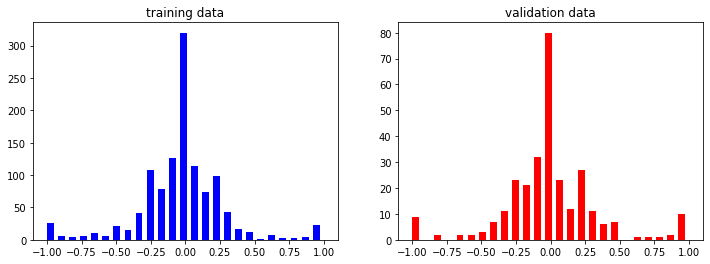

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins = num_bins, width = 0.05, color = 'blue') #plot histogram
axes[0].set_title('training data')
axes[1].hist(y_valid, bins = num_bins, width = 0.05, color = 'red')
axes[1].set_title('validation data')

In [ ]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3)) #zoom in 30%
  image = zoom.augment_image(image)
  return image

def pan(image):
  pan = iaa.Affine(translate_percent= {"x": (-0.1, 0.1), "y" : (-0.1, 0.1)}) #shift image randomly between 10% left to 10% right
  image = pan.augment_image(image)
  return image

def img_random_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2)) #multiply the intensity of the image with the valur from 0.2 to 1.2 
  image = brightness.augment_image(image)
  return image

def img_random_flip(image, steering_angle):
  image = cv2.flip(image, 1) #horizontal flip = flip the image mirror way
  steering_angle = -steering_angle # because we flip the image --> the car turn right change to turn left and vice versa
  return image, steering_angle



Text(0.5, 1.0, 'flipped image - steering angle: 0.1')

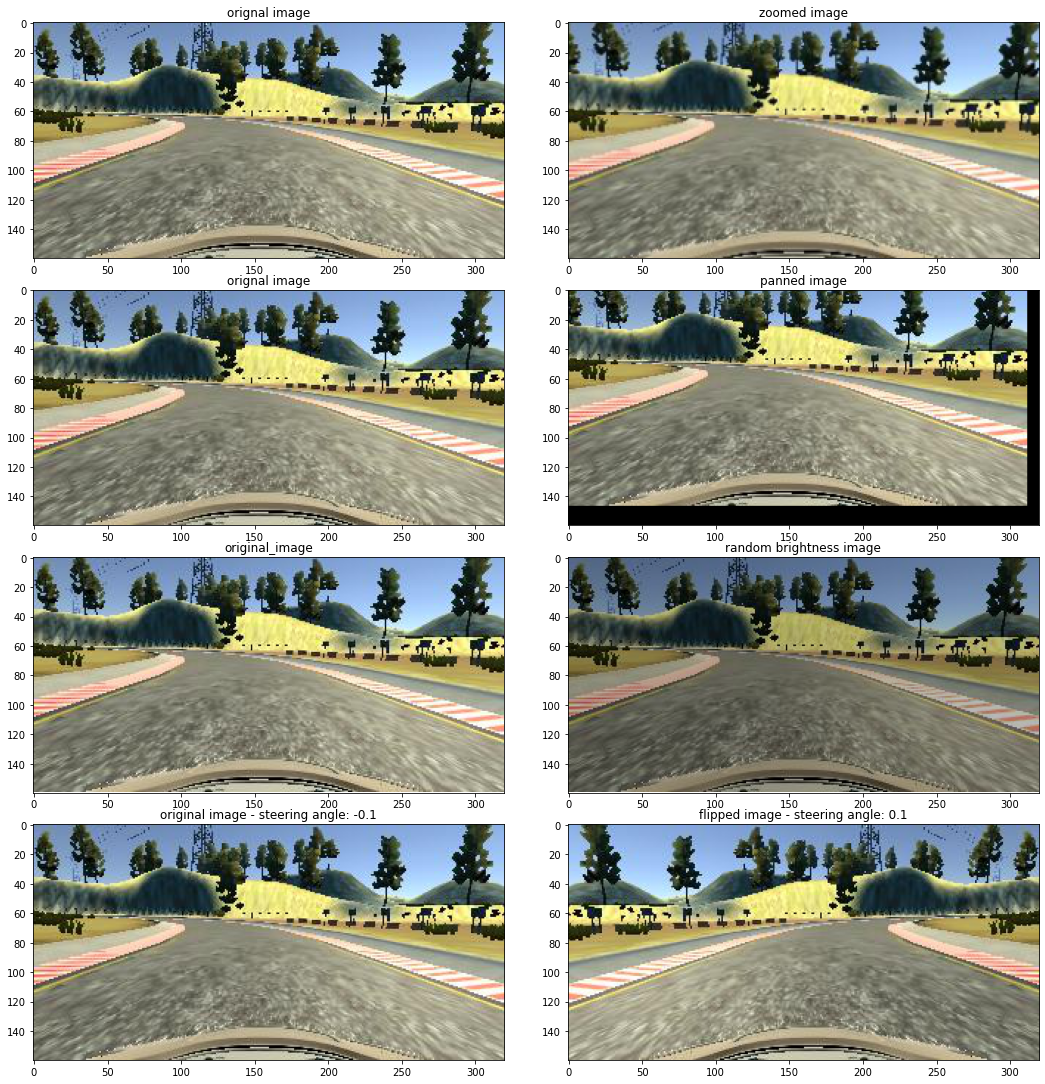

In [ ]:
#test the transformation functions
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]  #use for image flip as flip the image means flip the turning angle from right to left
                                          # and vice versa
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)
panned_image = pan(original_image)
brightness_image = img_random_brightness(original_image)
flipped_image, steering = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(4, 2, figsize = (15, 15))
fig.tight_layout()

axs[0][0].imshow(original_image)
axs[0][0].set_title("orignal image")

axs[0][1].imshow(zoomed_image)
axs[0][1].set_title("zoomed image")

axs[1][0].imshow(original_image)
axs[1][0].set_title("orignal image")

axs[1][1].imshow(panned_image)
axs[1][1].set_title("panned image")

axs[2][0].imshow(original_image)
axs[2][0].set_title("original_image")

axs[2][1].imshow(brightness_image)
axs[2][1].set_title("random brightness image")

axs[3][0].imshow(original_image)
axs[3][0].set_title("original image - " + 'steering angle: ' + str(steering_angle))

axs[3][1].imshow(flipped_image)
axs[3][1].set_title("flipped image - " + "steering angle: " + str(steering) )



In [ ]:
def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  if np.random.rand() < 0.5:
    image = zoom(image)

  if np.random.rand() < 0.5: # randomly choose 50% of the image data np.random.rand(),  will randomly output 1 random value at a time
    image = pan(image)       # ranging from 0 to 1 and we only take value that < 0.5 
                             # we can set function to how many value it gonna output by input the no of rows and no of columns
  if np.random.rand() < 0.5:
    image = img_random_brightness(image)

  if np.random.rand() < 0.5:
    image, steering_angle = img_random_flip(image, steering_angle)

  return image, steering_angle

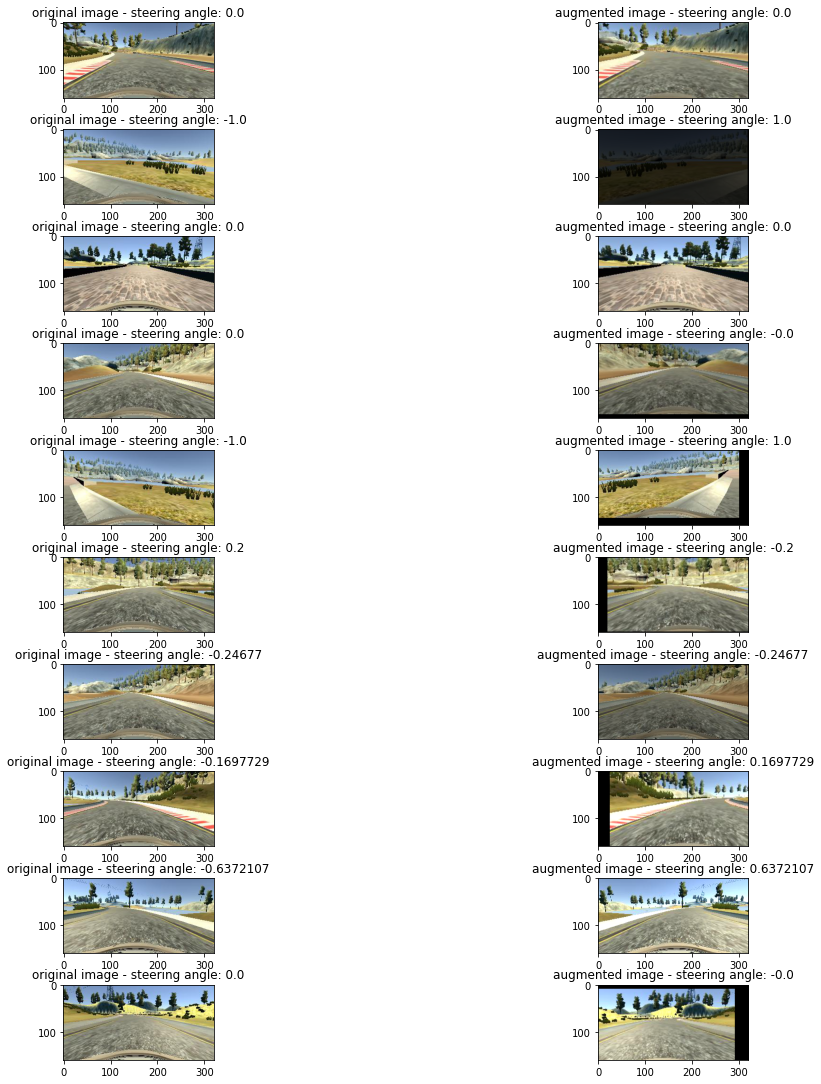

In [ ]:
# test the function random_augment
ncol = 2
nrow = 10 
image_lst = list()

fig, axs = plt.subplots(nrow, ncol, figsize = (15, 15))
fig.tight_layout()


for i in range(nrow):
  random_index = random.randint(0, 1000)
  random_image  = image_paths[random_index]
  random_steering_angle = steerings[random_index]
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering_angle)

  axs[i][0].imshow(original_image)
  axs[i][0].set_title("original image - " + "steering angle: " + str(random_steering_angle))

  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("augmented image - " + "steering angle: " + str(steering))

In [ ]:
def img_preprocessing(img):
  
  img = img[60:130, :, :] # to remove unnecessay detail
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV) #use this as we gonna use nvidia architech
  img = cv2.GaussianBlur(img, (3, 3), 0) #blur image
  img = cv2.resize(img, (200, 66))
  img = img/255 #normalize the intensity
  return img

In [ ]:
#image = image_paths[100]
#original_image = mpimg.imread(image)

#preprocessed_image = img_preprocessing(original_image)

#fig, axs = plt.subplots(1, 2, figsize = (15, 10)) #call the class subplots create 2d array of figures, 1st for number of rows, 
                                                  #2nd for number of columns
#fig.tight_layout()
#axs[0].imshow(original_image) # axs[0] for the first image
#axs[0].set_title('original img')
#axs[1].imshow(preprocessed_image)
#axs[1].set_title('preprocessed img')



In [ ]:
# instead of creating a whole agumented data set and store in memory, we will processing a small patch of images data at a time 
def batch_generator(image_paths, steering_ang, batch_size, istraining):

  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths)-1)

      if istraining: 
        im, steering = random_augment(image_paths[random_index], steerings[random_index])
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steerings[random_index]

      im = img_preprocessing(im)

      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

  """
function of yield statement in def function 
regularly variables in def function can not be stored as every we call the function, the variable will be reset, but in order 
for function to store the data, we have to use yield statement in order to save the data 

Note:
The istraining variable for considering if the data is from validation data set or training data set
when istraing is True (boolean value), the data set is training data,  we goona augment image and preprocessing for the model to train
but when istraining value is False, the data set is validation data, we not gonna augment image but still preprocessing as this to be the 
same as the original inorder for the post training to test 
  """

'\nfunction of next() statement:\nput in iterated number through all the data set, then output the value of dataset once at a time \n'

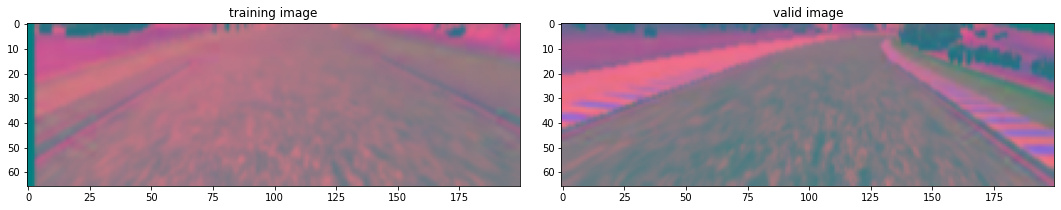

In [ ]:
#test the batch_generator function with different data type(training data and valid data)

X_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
X_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize = (15, 15))
fig.tight_layout()
axs[0].imshow(X_train_gen[0])
axs[0].set_title("training image")

axs[1].imshow(X_valid_gen[0])
axs[1].set_title("valid image")

"""
function of next() statement:
put in iterated number through all the data set, then output the value of dataset once at a time 
"""

In [ ]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, (5, 5), strides=(2, 2), input_shape = (66, 200, 3), activation='elu')) #input shape of img 66 height, 200 width , 3 color channels
  model.add(Convolution2D(36, (5, 5), strides=(2,2), activation='elu'))
  model.add(Convolution2D(48, (5, 5), strides=(2,2), activation='elu'))
  model.add(Convolution2D(64, (3, 3), activation='elu'))
  model.add(Convolution2D(64, (3, 3), activation='elu'))
# model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
#  model.add(Dropout(0.5))

  model.add(Dense(50, activation='elu'))
#  model.add(Dropout(0.5))
  model.add(Dense(10, activation='elu'))
 # model.add(Dropout(0.5))
  model.add(Dense(1))

  optimizer = Adam(lr = 1e-3)
  model.compile(loss='mse', optimizer = optimizer)

  return model

In [ ]:
model = nvidia_model()
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)              

In [ ]:
# modifying the input of fit() statement as we gonna put small agumented batch once at a time

history = model.fit(batch_generator(X_train, y_train, batch_size= 100, istraining=1), 
                    steps_per_epoch=300, 
                    epochs=10, 
                    validation_data=batch_generator(X_valid, y_valid, batch_size=100, istraining=0),
                    validation_steps = 200,
                    verbose=1, 
                    shuffle =1)

"""
the previous fit() statement gonna loop through the whole  preprocessed data set, however due to the insufficient accuracy
we gonna put input image to the batch_generator to randomize training datas and only preprocessnig our validation data
because we huge data, we have to use fit_generator() but the advantage is that the data will be processed on the fly instead
of processing the whole data and store it in memory, then put the data to learning model
"""

Epoch 1/10
300/300 [==============================] - 389s 1s/step - loss: 0.2908 - val_loss: 0.0366
Epoch 2/10
300/300 [==============================] - 385s 1s/step - loss: 0.1064 - val_loss: 0.0499
Epoch 3/10
300/300 [==============================] - 385s 1s/step - loss: 0.1157 - val_loss: 0.0486
Epoch 4/10
300/300 [==============================] - 385s 1s/step - loss: 0.1085 - val_loss: 0.0456
Epoch 5/10
300/300 [==============================] - 383s 1s/step - loss: 0.1090 - val_loss: 0.0433
Epoch 6/10
300/300 [==============================] - 385s 1s/step - loss: 0.1081 - val_loss: 0.0427
Epoch 7/10
300/300 [==============================] - 387s 1s/step - loss: 0.1065 - val_loss: 0.0460
Epoch 8/10
300/300 [==============================] - 384s 1s/step - loss: 0.1066 - val_loss: 0.0456
Epoch 9/10
300/300 [==============================] - 386s 1s/step - loss: 0.1055 - val_loss: 0.0441
Epoch 10/10
300/300 [==============================] - 387s 1s/step - loss: 0.1054 - val_lo

'\nthe previous fit() statement gonna loop through the whole  preprocessed data set, however due to the insufficient accuracy\nwe gonna put input image to the batch_generator to randomize training datas and only preprocessnig our validation data\nbecause we huge data, we have to use fit_generator() but the advantage is that the data will be processed on the fly instead\nof processing the whole data and store it in memory, then put the data to learning model\n'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  This i

Text(0.5, 0, 'epoch')

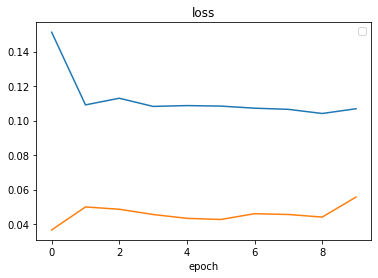

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend('training', 'validation')
plt.title('loss')
plt.xlabel('epoch')

In [ ]:
model.save('model.h5')

In [ ]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>